### Classifying drawn trajectories

In this dataset we have 3d drawn trajectories from 33 subjects. Each trajectory is a *circle*. During the drawing of each circle, the subject is observing either one or two avaters drawing. That can be the again *circles*, *diamonds*, or *triangles*.

Here we are using a simple classification approach.

### Highlights:
- taking as input drawn trajectories (100 data points of xyz positions)
- building up a **Linear Discriminant Analysis**
- using a Leave one out cross-validation approach
- testing the model performance on the test subject iteratively

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import sklearn
from sklearn import svm

### Loading the trajectories
The drawings have already been interpolated, each trajectory is 100 data points

In [2]:
xls = pd.ExcelFile('./SummaryAll_Y_2.xlsx')

# setting up subject list
subjlist = np.arange(1, 35)
subjlist = ['S00'+ str(x) if x<10 else'S0'+str(x) for x in subjlist ]
subjlist.remove('S028')  # outlier for catch trials


data1 = []
data2 = []
y1 = []
y2 = []

for s in subjlist:
    df = pd.read_excel(xls, s)

    # keeping only a subset of trial
    # drop practice
    df = df[df.Practice == 0]

    # keep only 1nC_2nT_3nD_4CC_5TT_6DD (no mix)
    df = df[df.ConditionN_0n_1nC_2nT_3nD_4CC_5TT_6DD_7CT_8CD_9TD < 7]
    df = df[df.ConditionN_0n_1nC_2nT_3nD_4CC_5TT_6DD_7CT_8CD_9TD != 0]

    # extracting xyz positions
    names = df.columns

    # separating by number of avatars
    df1 = df[df.ConditionN_0n_1nC_2nT_3nD_4CC_5TT_6DD_7CT_8CD_9TD < 4]
    df2 = df[df.ConditionN_0n_1nC_2nT_3nD_4CC_5TT_6DD_7CT_8CD_9TD > 3]

    # One avatar
    X = df1.loc[:, [x for x in names if x.startswith('Bin_X_')]]
    Y = df1.loc[:, [x for x in names if x.startswith('Bin_Y_')]]
    Z = df1.loc[:, [x for x in names if x.startswith('Bin_Z_')]]

    # extract condition
    condition = df1.ConditionN_0n_1nC_2nT_3nD_4CC_5TT_6DD_7CT_8CD_9TD
    shape = df1.ShapeObs_0N_1C_2T_3D_4mix
        
    # rearrange data points as n_trial x X x Y x Z
    pos = np.stack([X, Y, Z])
    pos = np.transpose(pos, (1, 0, 2))
    pos = np.reshape(pos, [len(condition), -1])

    # pos is our X data set
    data1.append(pos)
    y1.append(shape)

    # Two avatars
    X = df2.loc[:, [x for x in names if x.startswith('Bin_X_')]]
    Y = df2.loc[:, [x for x in names if x.startswith('Bin_Y_')]]
    Z = df2.loc[:, [x for x in names if x.startswith('Bin_Z_')]]

    # extract condition
    condition = df2.ConditionN_0n_1nC_2nT_3nD_4CC_5TT_6DD_7CT_8CD_9TD
    shape = df2.ShapeObs_0N_1C_2T_3D_4mix
        
    # rearrange data points as n_trial x X x Y x Z
    pos = np.stack([X, Y, Z])
    pos = np.transpose(pos, (1, 0, 2))
    pos = np.reshape(pos, [len(condition), -1])

    # pos is our X data set
    data2.append(pos)
    y2.append(shape)
    

### Explaining dimensions

We have two datasets, one for trials with one avatar moving, the other for trials with two avatars moving.
In each, X contains the XYZ trajectories for each trial, Y contain the shape identity (1: Circle, 2: Triangle, 3: Diamond)

Let's check what is the minimum number of trials*shape*participant to set up the crossvalidation folds.


In [3]:
nTrials1 = [len(i) for i in y1]
nTrials2 = [len(i) for i in y2]

print(f"On avarage, {np.mean(np.asarray(nTrials1))} per participant - one Avatar")
print(f"On avarage, {np.mean(np.asarray(nTrials2))} per participant - two Avatars")

nMin1 = [np.min(np.unique(i, return_counts  = True)[1]) for i in y1]
nMin2 = [np.min(np.unique(i, return_counts  = True)[1]) for i in y2]

print(f"Min number of trials per shape: {np.min(nMin1)} per participant - one Avatar")
print(f"Min number of trials per shape: {np.min(nMin2)} per participant - two Avatars")


On avarage, 29.393939393939394 per participant - one Avatar
On avarage, 29.393939393939394 per participant - two Avatars
Min number of trials per shape: 7 per participant - one Avatar
Min number of trials per shape: 8 per participant - two Avatars


### Plotting example trajectories

To better understand what we are dealing with, we will randomly pick 10 drawings and plot them.

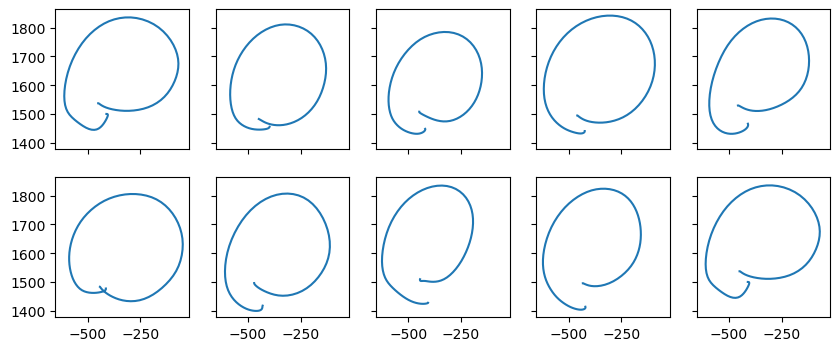

In [4]:
select = np.random.randint(len(data1[10]), size=10)
X_draw = data1[10][select, :]

f, axs = plt.subplots(2, 5, sharex = True, sharey = True, figsize = [10, 4])
for idx in range(len(select)):
    plt.subplot(2, 5, idx+1)
    plt.plot(X_draw[idx, 0:100], X_draw[idx, 200:300])

### Model training and testing in a crossvalidated loop

Following the cross-validation approach of Rocca 2023

- separate 1 avatar and 2 avatars
- check how many trials per shape we have
- 1000 iterations of svm
- in each iteration N trials are randomly selected for each participant, equally divided by shape
- k fold cross validation where k is the number of trials per shape in the selection above
- each fold has one trial per shape per participant

In [9]:
perm = 10
cv = 7
scores1 = np.zeros([cv, perm])
scores2 = []

# using a hack here, we treat each triplet of shapes per participant as a group 
# for stratified K fold
groups = np.tile(np.arange(7), 3*len(subjlist))

# One Avatar

for p in range(perm):
    print(f"--- Permutation: {p}")

    # gotta get in each participant and extract 7 for each shape

    X = []
    Y = []

    for idx_s, subj in enumerate(subjlist):

        this_x = data1[idx_s]
        this_y = np.array(y1[idx_s])

        indices1 = np.where(this_y == 1)[0]
        indices2 = np.where(this_y == 2)[0]
        indices3 = np.where(this_y == 3)[0]

        # randomly selecting 7
        indices1_sel = np.random.choice(indices1, cv, replace = False)
        indices2_sel = np.random.choice(indices2, cv, replace = False)
        indices3_sel = np.random.choice(indices3, cv, replace = False)

        indices = np.concat([indices1_sel, indices2_sel, indices3_sel])
        
        X.append(this_x[indices1_sel, :])
        X.append(this_x[indices2_sel, :])
        X.append(this_x[indices3_sel, :])

        Y.append(this_y[indices])


    X = np.vstack(X)
    Y = np.hstack(Y)

    
    # stratified k-fold keeping the folds
    skf = sklearn.model_selection.LeaveOneGroupOut()

    for i, (train_index, test_index) in enumerate(skf.split(X, Y, groups)):

        X_train = X[train_index]
        X_test = X[test_index]
        
        y_train = Y[train_index]
        y_test = Y[test_index]

        # scaling training set
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(X_train)
    
        # training the model
        svc = svm.SVC()
        model = svc.fit(x_train_scaled, y_train)

        x_test_scaled = scaler.transform(X_test)

        scores1[i, p] = model.score(x_test_scaled, y_test)
        
    

--- Permutation: 0
--- Permutation: 1
--- Permutation: 2
--- Permutation: 3
--- Permutation: 4
--- Permutation: 5
--- Permutation: 6
--- Permutation: 7
--- Permutation: 8
--- Permutation: 9


In [10]:
perm = 10
cv = 7
scores2 = np.zeros([cv, perm])

# using a hack here, we treat each triplet of shapes per participant as a group 
# for stratified K fold
groups = np.tile(np.arange(7), 3*len(subjlist))

# One Avatar

for p in range(perm):
    print(f"--- Permutation: {p}")

    # gotta get in each participant and extract 7 for each shape

    X = []
    Y = []

    for idx_s, subj in enumerate(subjlist):

        this_x = data2[idx_s]
        this_y = np.array(y2[idx_s])

        indices1 = np.where(this_y == 1)[0]
        indices2 = np.where(this_y == 2)[0]
        indices3 = np.where(this_y == 3)[0]

        # randomly selecting 7
        indices1_sel = np.random.choice(indices1, cv, replace = False)
        indices2_sel = np.random.choice(indices2, cv, replace = False)
        indices3_sel = np.random.choice(indices3, cv, replace = False)

        indices = np.concat([indices1_sel, indices2_sel, indices3_sel])
        
        X.append(this_x[indices1_sel, :])
        X.append(this_x[indices2_sel, :])
        X.append(this_x[indices3_sel, :])

        Y.append(this_y[indices])


    X = np.vstack(X)
    Y = np.hstack(Y)

    
    # stratified k-fold keeping the folds
    skf = sklearn.model_selection.LeaveOneGroupOut()

    for i, (train_index, test_index) in enumerate(skf.split(X, Y, groups)):

        X_train = X[train_index]
        X_test = X[test_index]
        
        y_train = Y[train_index]
        y_test = Y[test_index]

        # scaling training set
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(X_train)
    
        # training the model
        svc = svm.SVC()
        model = svc.fit(x_train_scaled, y_train)

        x_test_scaled = scaler.transform(X_test)

        scores2[i, p] = model.score(x_test_scaled, y_test)
        
    

--- Permutation: 0
--- Permutation: 1
--- Permutation: 2
--- Permutation: 3
--- Permutation: 4
--- Permutation: 5
--- Permutation: 6
--- Permutation: 7
--- Permutation: 8
--- Permutation: 9


In [11]:
scores1 = np.mean(scores1, axis = 0)
scores2 = np.mean(scores2, axis = 0)

([<matplotlib.axis.XTick at 0x197e5a04c70>,
 [Text(0, 0, 'One Avatar'), Text(1, 0, 'Two Avatars')])

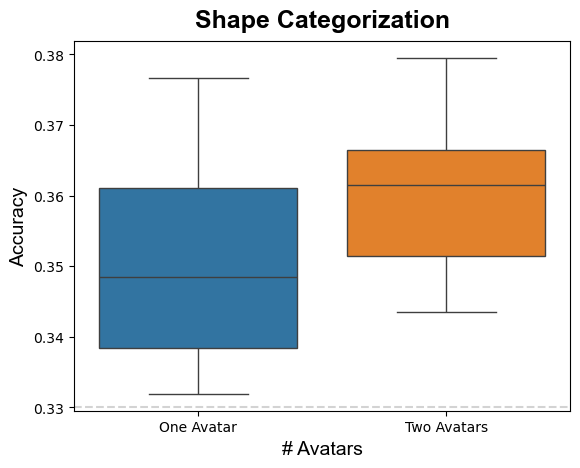

In [12]:
plt.figure()

sns.boxplot([scores1, scores2])
plt.axhline(.33, color = 'lightgray', linestyle = '--')
plt.title('Shape Categorization', fontdict=dict(fontsize= 18, font = 'Arial', fontweight='bold'), pad = 10)
plt.xlabel('# Avatars', fontdict=dict(fontsize= 14, font = 'Arial'))
plt.ylabel('Accuracy', fontdict=dict(fontsize= 14, font = 'Arial'))
plt.xticks(ticks = [0, 1],labels = ['One Avatar', 'Two Avatars'])
